In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""
Copy all the files to a local directory, because I don't have the right permissions on RDSF

"""
import os
import yaml
import shutil
import pathlib
from tqdm import tqdm

# Create an output file directory
battery_dir = "data/battery_dbs/"
if not os.path.isdir(battery_dir):
    os.makedirs(battery_dir)

# Find all the files
with open("config.yaml", "r") as stream:
    dirname = "/mnt/z/" + yaml.safe_load(stream)["smartwatch_dbs_dir"]
dirname = pathlib.Path(dirname)
assert dirname.exists()

# Recurse into all "Week X" directories, extracting all .db files
source_files = [file for file in dirname.glob("Week*/**/*.db")]
dest_files = [os.path.join(battery_dir, file.name) for file in source_files]

# Check that they don't all exist
if not all([os.path.isfile(dest) for dest in dest_files]):
    for source, dest in tqdm(zip(source_files, dest_files), total=len(source_files)):
        assert not os.path.isfile(dest), f"Duplicate name {source}"
        shutil.copyfile(source, dest)

In [3]:
"""
Create a csv of p_id, timestamp and battery level

"""
import sqlite3
import pandas as pd


dfs = []

for path in tqdm(dest_files):
    # Get the p_id from the path
    path = pathlib.Path(path)
    p_id = path.name.split("_")[1]

    # Open the db
    conn = sqlite3.connect(path, uri=True)

    # Get the battery level
    try:
        df = pd.read_sql_query("SELECT * FROM Event;", conn)

    except pd.io.sql.DatabaseError as e:
        print(f"{path} failed with {e}")
        continue

    # Only keep battery level rows
    df = df[df["eventdesc"].str.startswith("B")]

    # Add a new column for timestamp
    df["Datetime"] = pd.to_datetime(
        df["eventdate"] + " " + df["eventtime"], format="%Y-%m-%d %H:%M:%S"
    )
    df["battery_lvl"] = df["eventdesc"].str.split(" ").str[-1].str[:-1].astype(int)

    df["p_id"] = p_id

    dfs.append(df[["p_id", "Datetime", "battery_lvl"]])

    conn.close()

battery_level_df = pd.concat(dfs)
battery_level_df.head()

100%|██████████| 77/77 [00:00<00:00, 403.03it/s]

data/battery_dbs/EMADATA_15082_20220420.db failed with Execution failed on sql 'SELECT * FROM Event;': database disk image is malformed
data/battery_dbs/EMADATA_20050_20220412.db failed with Execution failed on sql 'SELECT * FROM Event;': database disk image is malformed
data/battery_dbs/EMADATA_29061_20220628.db failed with Execution failed on sql 'SELECT * FROM Event;': database disk image is malformed
data/battery_dbs/EMADATA_4260_20211221.db failed with Execution failed on sql 'SELECT * FROM Event;': database disk image is malformed
data/battery_dbs/EMADATA_27345_20220615.db failed with Execution failed on sql 'SELECT * FROM Event;': database disk image is malformed
data/battery_dbs/EMADATA_35272_20220520.db failed with Execution failed on sql 'SELECT * FROM Event;': database disk image is malformed
data/battery_dbs/EMADATA_3017_20220204.db failed with Execution failed on sql 'SELECT * FROM Event;': database disk image is malformed
data/battery_dbs/EMADATA_23532_20220204.db failed 

,p_id,Datetime,battery_lvl
2,765,2022-04-12 12:56:52,22
5,765,2022-04-12 12:59:06,25
8,765,2022-04-12 14:01:50,99
12,765,2022-04-12 16:31:37,100
15,765,2022-04-12 17:32:11,99


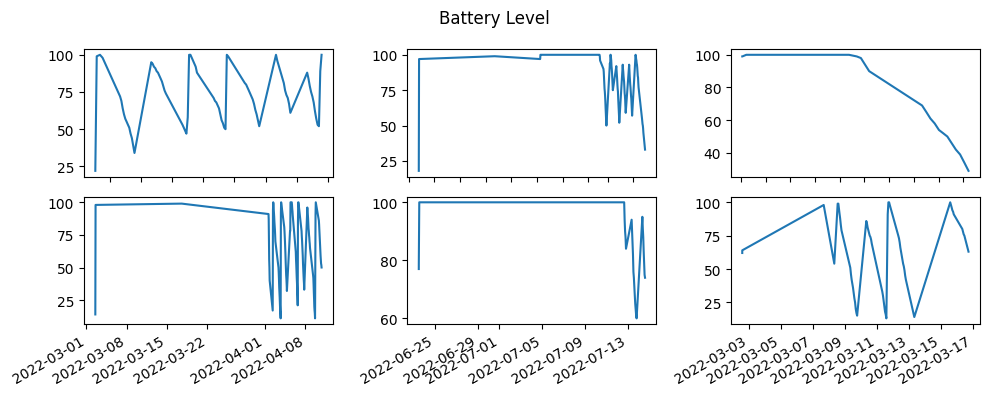

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(10, 4))

for pid, axis in zip(battery_level_df["p_id"].unique(), axes.flat):
    slice_ = battery_level_df[battery_level_df["p_id"] == pid].sort_values("Datetime")
    axis.plot(slice_["Datetime"], slice_["battery_lvl"], "-")

fig.suptitle("Battery Level")

fig.autofmt_xdate()
fig.tight_layout()

imgdir = "img/battery_level"
if not os.path.isdir(imgdir):
    os.makedirs(imgdir)
fig.savefig(f"{imgdir}/battery_level.png")

In [5]:
"""
Find the start day of each participant

"""
from ema import read

battery_df = battery_level_df.copy()
battery_df["p_id"] = battery_df["p_id"].astype(int)
battery_df = battery_df.set_index(battery_df["Datetime"]).drop(columns=["Datetime"])

battery_df = read.add_timedelta(battery_df)
len(battery_df)

5879

In [6]:
"""
Remove negative delta and deltas above 7

"""
battery_df = battery_df[battery_df["delta"].dt.days >= 0]
battery_df = battery_df[battery_df["delta"].dt.days <= 7]
len(battery_df)

4974

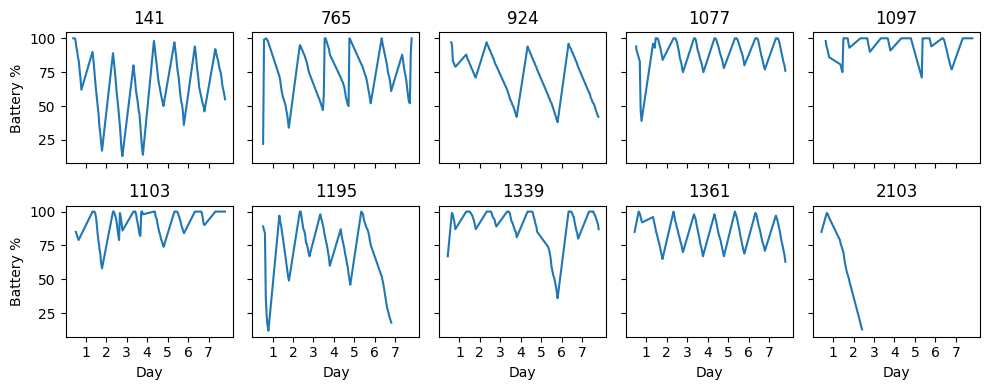

In [7]:
"""
Plot battery level against delta

"""
from itertools import islice
import numpy as np

fig, axes = plt.subplots(2, 5, figsize=(10, 4), sharex=True, sharey=True)

for axis, (p_id, grp) in zip(axes.flat, islice(battery_df.groupby("p_id"), 10)):
    axis.plot(grp["delta"].dt.total_seconds(), grp["battery_lvl"])
    axis.set_title(p_id)

for axis in axes[:, 0]:
    axis.set_ylabel("Battery %")
for axis in axes[1]:
    axis.set_xlabel("Day")

# Convert x labels to days
axis.set_xticks(np.arange(1, 8) * 24 * 3600, range(1, 8))

fig.tight_layout()
fig.savefig(f"{imgdir}/battery_level_vs_delta.png")

In [8]:
"""
Find which participants made 0/few entries on the last day of the study

"""

'\nFind which participants made 0/few entries on the last day of the study\n\n'

In [9]:
"""
Plot the battery level of people who made few entries on the last day

"""

'\nPlot the battery level of people who made few entries on the last day\n\n'

In [10]:
"""
Plot battery level of people who made a lot of entries on the last day

"""

'\nPlot battery level of people who made a lot of entries on the last day\n\n'

In [11]:
"""
Scatter plot showing number of entries per day vs battery level on that day, colour coded by day

"""

'\nScatter plot showing number of entries per day vs battery level on that day, colour coded by day\n\n'